In [ ]:
import tensorflow as tf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers

The data is available at https://www.transelectrica.ro/widget/web/tel/sen-grafic/-/SENGrafic_WAR_SENGraficportlet
Transelectrica maintains a database with all values of the instantaneous power consumption and production:
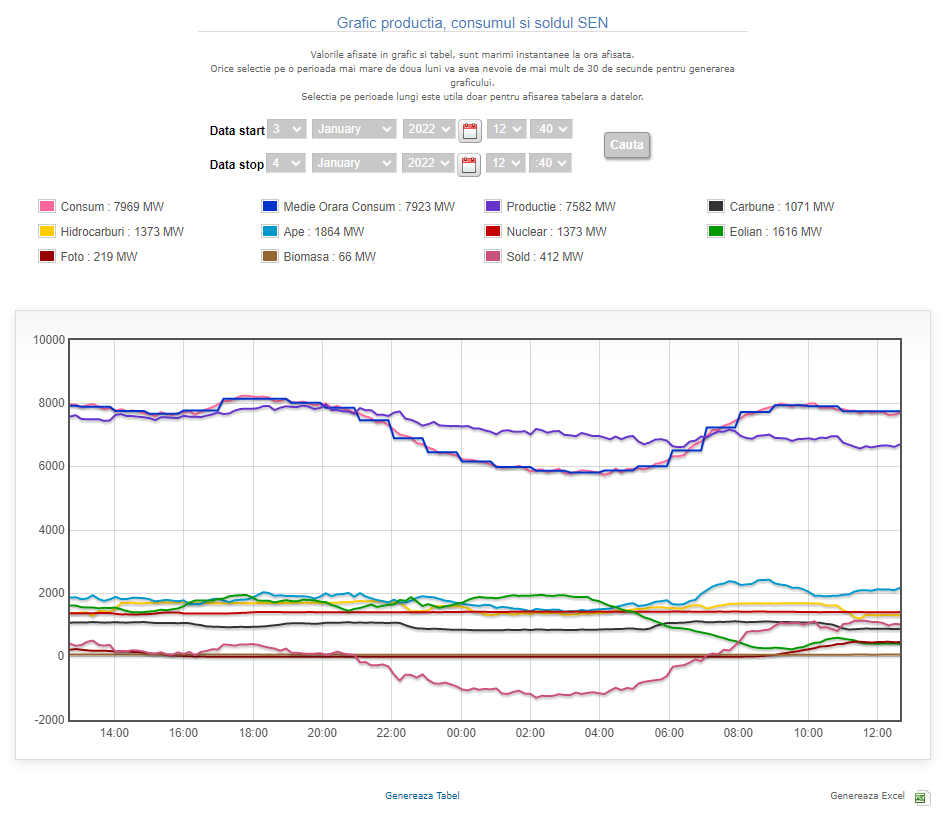


The data used in this project is a selection starting on 23rd October 2013, 00:28:58 until 23rd October 2021, 00:20:19:
  
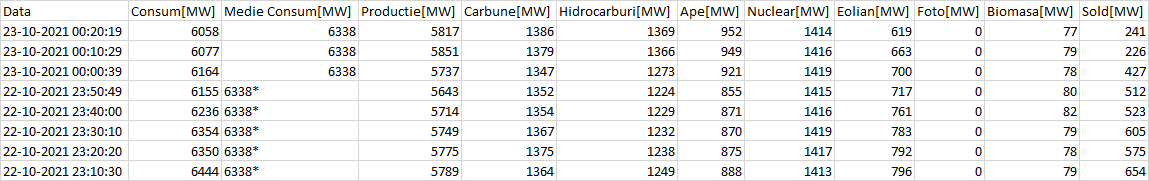                  

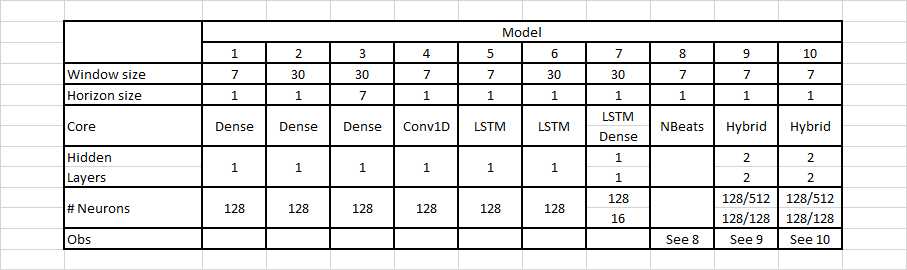

In [ ]:
# Reads data from the disk
data = pd.read_csv("D:\\Lucrare Nov 2021\\Grafic_SEN_A.csv", low_memory=False)

In [ ]:
data

In [ ]:
#Creates a Pandas Series object converting the string values from the 'Data' column to date-time objects
data_f = pd.Series(map(lambda x: datetime.strptime(x, "%d-%m-%Y %H:%M:%S"), data['Data']))

In [ ]:
#Raw data can contain numeric values with a "*". This function removes the "*" and leaves the numeric value
def remove_star(target_string):
    return target_string.translate({ord("*"): None})

In [ ]:
#Creates a Pandas dataframe as follows:
# Column 1: Date as a DateTime object
# Column 2: Momentary value of consumption in MW after removing the star character wherever it occurs
data_X = pd.DataFrame({"Data": data_f, "Instantaneous load":pd.Series(map(remove_star, data["Consum[MW]"]))})

In [ ]:
#Creates a Pandas series containing the weekday (M,T,W,T,F,S,S) for each DateTime value
data_series_weekday= pd.Series(map(lambda x: x.weekday(), data_X["Data"]))

In [ ]:
#Creates a list of year values by extracting the year value from each DateTime object in the Series
def create_year_list(data_series):
    s  = list(map(lambda x: x.year, data_series))
    print(f"Lungimea sirului este {len(s)}")
    return set(s)

In [ ]:
list_of_days = []
year_check_table = []
#Creates a list of year values
year_values_list = list(create_year_list(data_X["Data"]))
# b = year_values_list.sort()
year_values_list.sort()

In [ ]:
year_values_list


In [ ]:
# Creates a DataFrame object with two columns: 
# (1) Date in the format d-m-Y as a DateTime object and (2) momentary load as a string object
data_X = pd.DataFrame({"Data": data_f, "Consum":data["Consum[MW]"]})

In [ ]:
# Character "*" is removed from the string values in column "Consum"
data_X = pd.DataFrame({"Data": data_X["Data"], "Consum": map(remove_star, data_X["Consum"])})

In [ ]:
a

In [ ]:
list_of_days = []
year_check_table = []
a = list(create_year_list(data_X["Data"]))
a.sort()
for i in a:
    year_check_table.append(i)
    for j in range(1,13):
        # Selects the list of datetime objects from data_X["Data"] where year equals "i" and month equals "j":
        full_list_of_days_per_month = data_X["Data"][map(lambda x: x.year == i and x.month == j, data_X["Data"])]
        
        # Extracts the list of days from the datetime objects selected above
        list_of_days_per_month = list(map(lambda x: x.day, full_list_of_days_per_month))
        
        # Duplicates are eliminated by defining a set object
        list_of_days_set = list(set(list_of_days_per_month))
        
        # A list of months included in the analysis interval is created. 
        # Each element of the list is the list of days in that particular month
        list_of_days.append(list_of_days_set)

# The list is converted to a numpy array and reshaped: the first dimension is the number of years in the analysis interval
# The second dimension is 12 - the number of months in a year
final_list = np.array(list_of_days, dtype=np.object).reshape(len(year_check_table),12)

In [ ]:
final_list[0]

In [ ]:
final_list.shape

In [ ]:
year_check_table.sort()
year_check_table

In [ ]:
datetime(2021,10,22).weekday()

In [ ]:
DayIndex = []
DailyEnergy = []
DateTime = []
Weekday = []
i = 1
No = []
for index_year, year in enumerate(final_list):
    for index_month, month in enumerate(year):
        for days in month:
            print(year_check_table[index_year], index_month, days)
            # A mask is defined in order to select the datetime object from the full data_X dataframe that refer to a specific day:
            filterx = list(map(lambda x: (x.year == year_check_table[index_year]) and (x.month == index_month+1) and (x.day == days) , data_X["Data"]))
            
            # Datetime objects are selected from the data_X dataframe based on the mask values defined above
            data_series = data_X["Data"][filterx]
            
            # The corresponding values of the momentary consumption for the current day are extracted:
            consumption_series_raw = data_X["Consum"][data_series.index]
            
            # The consumption values extracted above in the form of a pandas series object are converted to float32
            consumption_series = pd.Series(list(map(lambda x: np.float32(x), consumption_series_raw)))   
            
            # The time interval between two data points is determined by subtracting the shifted datetime series from the original
            delta_time = data_series.shift() - data_series
            
            # The time interval between two data points is converted to seconds
            delta_time_seconds = list(map(lambda x: x.seconds, delta_time[1:]))
            
            # In order to perform integration of the momentary power consumption over the one day interval, the arithmetic mean between
            # two consecutive values is determined:
            daily_ave_consumption = (consumption_series[1:] + consumption_series.shift()[1:])/2
            
            print(f"Current date is: {year_check_table[index_year]} / {index_month+1} / {days} weekday is: {datetime(year_check_table[index_year],index_month+1,days).weekday()}")
            DayIndex.append(days)
            
            # Integration by trapezoidal rule is performed as the dot product between the arithmetic mean determined above and the 
            # time interval in seconds between two data points            
            DailyEnergy.append(np.dot(delta_time_seconds, daily_ave_consumption)/3600/24)
            
            # Date in the format Y-m-d is generated as a list
            DateTime.append(datetime(year_check_table[index_year],index_month+1,days))
            
            # Weekday in the formart 0-6 is generated as a list
            Weekday.append(datetime(year_check_table[index_year],index_month+1,days).weekday())
            
            No.append(i)
            i = i + 1
# A pandas dataframe object is created: 
# No - index
# Date/Time - date in the format Y-m-d
# Day index - the day index in the current month
# Energy - the total energy for that particular day
# Weekday - in the format 0-6
DF = pd.DataFrame({"No":No, "Date/Time":DateTime, "Day index":DayIndex, "Energy":DailyEnergy, "Weekday":Weekday})
plt.plot(DF["Date/Time"][:len(DF)-2], DF["Energy"][:len(DF)-2])

In [ ]:
DF.head()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
DF.to_csv("D:\\Lucrare Nov 2021\\DF.csv")

In [ ]:
import pandas as pd
DF = pd.read_csv("D:\\Lucrare Nov 2021\\DF.csv")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(DF["Date/Time"][:len(DF)-2], DF["Energy"][:len(DF)-2])

In [ ]:
list_time = DF["Date/Time"][:-1].to_numpy()
list_cons = DF["Energy"][:-1].to_numpy()

In [ ]:
list_time[-1], list_cons[-1]

In [ ]:
list_time.shape, list_cons.shape

In [ ]:
timesteps = DF["Date/Time"].to_numpy()
timesteps[:10]

In [ ]:
list_cons[-1]

In [ ]:
type(list_time), type(list_cons)

In [ ]:
len(list_cons[2338:]), len(timesteps[2338:])

In [ ]:
split_size = int(0.8 * len(list_cons))
#Create train data splits
X_train, y_train = list_time[:split_size], list_cons[:split_size]
X_test, y_test = list_time[split_size+1:], list_cons[split_size+1:]
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
def make_predictions(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
def get_labelled_windows(x, horizon=HORIZON):
    return x[:,:-horizon], x[:,-horizon:]



In [ ]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    # numpy broadcasting principle is applied here to obtain an array of indexes
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")
    windowed_array = x[window_indexes]
    # print(windowed_array)
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [ ]:
full_windows, full_labels = make_windows(list_cons, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

In [ ]:
#MASE 
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    mape = tf.keras.metrics.mape(y_true, y_pred)
    return {'mae': mae.numpy(),
            'mse': mse.numpy(),
            'rmse': rmse.numpy(),
            'mase': mase.numpy(),
            'mape': mape.numpy()}

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

In [ ]:
test_labels[-2:]

In [ ]:
train_labels

In [ ]:
from tensorflow.keras import layers

In [ ]:
import os
def create_model_checkpoint(model_name, save_path='D:\\Lucrare Nov 2021'):
    
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                              monitor='val_loss', 
                                              verbose=0,
                                              save_best_only=True)

In [ ]:
HORIZON = 1 
WINDOW_SIZE = 7

# Model 1. Simple Dense model, one single layer, 128 neurons 
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
history_1 = model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')

model_1.compile(loss='mae',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=1000,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [ ]:
# Reload the saved model with the best validation loss value
model_1 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_1_dense")

In [ ]:
model_1.evaluate(test_windows, test_labels)

In [ ]:
model_1_preds = make_predictions(model_1, test_windows)

In [ ]:
model_1_preds[:10], len(model_1_preds)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

In [ ]:
train_windows.shape, test_windows.shape

In [ ]:
short_window = list_cons[-WINDOW_SIZE:]
short_window.reshape(1,-1).shape

In [ ]:
tf.squeeze(model_1.predict(short_window.reshape(1,-1))).numpy()

In [ ]:
list_init

In [ ]:
list_init = list_cons[-WINDOW_SIZE:]


In [ ]:
preds = []
for i in range(100):
    new_pred = tf.squeeze(model_1.predict(list_init.reshape(1,-1))).numpy()    
    preds.append(new_pred)
    list_init = list(list_init)    
    list_init.append(new_pred)    
    list_init = np.array(list_init[1:])

In [ ]:
preds[:10]

In [ ]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
   
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Energy")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [ ]:
plot_time_series(timesteps=X_train, values=y_train)
plot_time_series(timesteps=X_test, values=y_test)

In [ ]:
offset = 520
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels,start=offset, format='-', label='Test data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset,  label='Predictions')

In [ ]:
X_test[0]

In [ ]:
DF.columns

In [ ]:
type(DF["Date/Time"][0])

# Model 2. Simple Dense model, one single layer, 128 neurons 
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(list_cons, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear')
], name='model_2_dense')

model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

history_2 = model_2.fit(train_windows,
            train_labels,
            epochs=1000,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
model_2.evaluate(test_windows, test_labels)

In [ ]:
model_2 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_2_dense")

In [ ]:
model_2_preds = make_predictions(model=model_2,
                                 input_data=test_windows)
model_2_preds

In [ ]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

In [ ]:
offset = 520
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels,start=offset, format='-', label='Test data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset,  label='Predictions')

# Model 3. Simple Dense model, one single layer, 128 neurons 
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(list_cons, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

model_3 = tf.keras.Sequential([
                               layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear')
], name='model_3_dense')

model_3.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

history_3 = model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
model_3 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_3_dense")
model_3.evaluate(test_windows)

In [ ]:
model_3_preds = make_predictions(model_3, test_windows)
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

In [ ]:
offset = 520
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format='-', start=offset,  label="model_3_preds")

# Model 4. Conv1D model, one single layer, 128 neurons 
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
full_windows, full_labels = make_windows(list_cons, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

model_4 = tf.keras.models.Sequential([
                                      layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                                      layers.Conv1D(filters=128,
                                                    kernel_size=7,
                                                    padding='causal',
                                                    activation='relu'),
                                      layers.Dense(HORIZON)
], name='model_4_Conv1D')

model_4.compile(loss='mae',
                optimizer='adam')

history_4 = model_4.fit(train_windows, 
            train_labels, 
            batch_size=128, 
            epochs=1000, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_4_Conv1D")

In [ ]:
model_4_preds = make_predictions(model_4,
                                 test_windows)
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

In [ ]:
offset = 520
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_4_preds, format='-', start=offset,  label="model_4_preds")

# Model 5. LSTM model 1 
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
full_windows, full_labels = make_windows(list_cons, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
# x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)
model_5_LSTM_API = tf.keras.models.Model(inputs, outputs, name='model_5_LSTM_API')

model_5_LSTM_API.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

history_5 = model_5_LSTM_API.fit(train_windows,
                     train_labels,
                     epochs=1000,
                     batch_size=128,
                     verbose=0,
                     validation_data=(test_windows, test_labels),
                     callbacks=[create_model_checkpoint(model_name=model_5_LSTM_API.name)]
                     )

In [ ]:
model_5 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_5_LSTM_API")

In [ ]:
model_5_LSTM_API_preds = make_predictions(model_5_LSTM_API,
                                 test_windows)
model_5_LSTM_API_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_LSTM_API_preds)
model_5_LSTM_API_results

# Model 6. LSTM model 2 
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(list_cons, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
# x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)
model_6_LSTM_API = tf.keras.models.Model(inputs, outputs, name='model_6_LSTM_API')

model_6_LSTM_API.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

history_6 = model_6_LSTM_API.fit(train_windows,
                     train_labels,
                     epochs=1000,
                     batch_size=128,
                     verbose=1,
                     validation_data=(test_windows, test_labels),
                     callbacks=[create_model_checkpoint(model_name=model_6_LSTM_API.name)]
                     )

In [ ]:
model_6 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_6_LSTM_API")

In [ ]:
model_6_LSTM_API_preds = make_predictions(model_6_LSTM_API,
                                 test_windows)
model_6_LSTM_API_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_6_LSTM_API_preds)
model_6_LSTM_API_results

In [ ]:
offset = 500
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_6_LSTM_API_preds, format='-', start=offset,  label="model_6_LSTM_preds")

# Model 7. LSTM model: One LSTM layer (no return sequence) plus one Dense layer 
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(list_cons, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)
model_7_LSTM_API = tf.keras.models.Model(inputs, outputs, name='model_7_LSTM_API')
model_7_LSTM_API.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
history_7 = model_7_LSTM_API.fit(train_windows,
                     train_labels,
                     epochs=1000,
                     batch_size=128,
                     verbose=1,
                     validation_data=(test_windows, test_labels),
                     callbacks=[create_model_checkpoint(model_name=model_7_LSTM_API.name)]
                     )

In [ ]:
model_7 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_7_LSTM_API")
model_7_LSTM_API_preds = make_predictions(model_7_LSTM_API,
                                 test_windows)
model_7_LSTM_API_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_7_LSTM_API_preds)
model_7_LSTM_API_results

In [ ]:
offset = 530
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_7_LSTM_API_preds, format='-', start=offset,  label="model_6_LSTM_preds")

# Model 8. N-BEATS model based on the paper NEURAL BASIS EXPANSION ANALYSIS FOR INTERPRETABLE TIME SERIES FORECASTING
HORIZON = 1
WINDOW_SIZE = 7

N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR INTERPRETABLE TIME SERIES FORECASTING, Boris N. Oreshkin et al., published at ICLR 2020

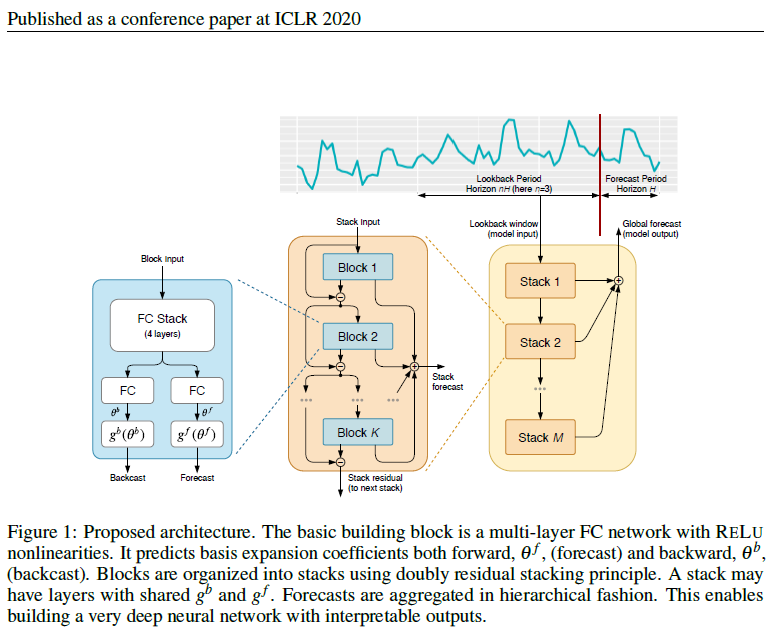

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
        return backcast, forecast



In [ ]:
HORIZON = 1 
WINDOW_SIZE = 7


dummy_block = NBeatsBlock(input_size=WINDOW_SIZE,
                          theta_size=WINDOW_SIZE+HORIZON,
                          horizon=HORIZON,
                          n_neurons=128,
                          n_layers=4,
                          name="dummy_NNBeats")


dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE), axis=0)

b, f = dummy_block(dummy_inputs)
b,f
list_cons_nbeats = pd.DataFrame(list_cons, columns=["Consum"])
list_cons_nbeats

In [ ]:
for i in range(WINDOW_SIZE):
    list_cons_nbeats[f"Cons {i+1}"] = list_cons_nbeats["Consum"].shift(periods=i+1)
list_cons_nbeats

In [ ]:
X = list_cons_nbeats.dropna().drop("Consum", axis=1)
y = list_cons_nbeats.dropna()["Consum"]
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
train_features = tf.data.Dataset.from_tensor_slices(X_train)
train_labels = tf.data.Dataset.from_tensor_slices(y_train)
test_features = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_ds = tf.data.Dataset.from_tensor_slices(y_test)
train_dataset = tf.data.Dataset.zip((train_features, train_labels))
test_dataset = tf.data.Dataset.zip((test_features, test_labels_ds))
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [ ]:
len(test_labels_ds), len(y_test)

In [ ]:
X_test

In [ ]:
N_EPOCHS = 1000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON

In [ ]:
%%time
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS
                                 )
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE,), name="split_size")
residuals, forecast = nbeats_block_layer(stack_input)
for i, _ in enumerate(range(N_STACKS-1)):
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                     theta_size=THETA_SIZE,
                                     horizon=HORIZON,
                                     n_neurons=N_NEURONS,
                                     n_layers=N_LAYERS)(residuals)
    residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

model_8_NBEATS = tf.keras.Model(inputs=stack_input, outputs=forecast, name="NBeats_model")
model_8_NBEATS.compile(loss="mae", optimizer="adam")
model_8_NBEATS.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,            
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            ),
                      create_model_checkpoint(model_8_NBEATS.name)])

In [ ]:
model_8_NBEATS = tf.keras.models.load_model("D:\Lucrare Nov 2021\\NBeats_model")

In [ ]:
model_8_NBEATS_preds = make_predictions(model_8_NBEATS, test_dataset)

In [ ]:
model_8_NBEATS_preds.shape, y_test.shape

In [ ]:
model_8_NBEATS_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_8_NBEATS_preds)
model_8_NBEATS_results

In [ ]:
model_8_NBEATS_preds = make_predictions(model_8_NBEATS, test_dataset)
model_8_NBEATS_preds

In [ ]:
model_8_NBEATS = tf.keras.models.load_model("D:\Lucrare Nov 2021\\NBeats_model")

In [ ]:
model_8_NBEATS_preds.shape, y_test.shape

In [ ]:
model_8_NBEATS_results =evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_8_NBEATS_preds)
model_8_NBEATS_results

In [ ]:
test_labels.shape, X_test.shape

In [ ]:
X_test_plot, y_test_plot = list_time[split_size+1:], list_cons[split_size+1:]
offset = 530
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test_plot[-len(y_test_plot):], values=tf.squeeze(y_test_plot),start=offset, format='-', label='Test data')
plot_time_series(timesteps=X_test_plot[-len(model_8_NBEATS_preds):], values=model_8_NBEATS_preds, start=offset, format='.', label="model_7_preds")

In [ ]:
len(X_test), len(model_7_preds)

# Model 9. Hybrid model. Weekday (0-6) is considered a separate variable and fed to the model through an independent path. Weekday is considered an integer

In [ ]:
HORIZON = 1 
WINDOW_SIZE = 7

input_consumption = tf.keras.layers.Input(shape=(WINDOW_SIZE,))
x = tf.keras.layers.Dense(128, activation="relu")(input_consumption)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs_consumption = tf.keras.layers.Dense(128)(x)
model_9_hybrid_consumption = tf.keras.Model(inputs=input_consumption, outputs=outputs_consumption)

input_weekday = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(128, activation="relu")(input_weekday)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs_weekday = tf.keras.layers.Dense(256, activation="relu")(x)
model_9_hybrid_weekday = tf.keras.Model(inputs=input_weekday, outputs=outputs_weekday)

hybrid_concat = tf.keras.layers.Concatenate(name="model_9_hybrid")([model_9_hybrid_consumption.output,
                                                                           model_9_hybrid_weekday.output])

combined_dropout = tf.keras.layers.Dropout(0.5)(hybrid_concat)
combined_dense = tf.keras.layers.Dense(8, activation="relu")(combined_dropout)
combined_dense_2 = tf.keras.layers.Dense(8, activation="relu")(combined_dense)
output_layer = tf.keras.layers.Dense(HORIZON)(combined_dense_2)

model_9_hybrid = tf.keras.Model(inputs=[input_consumption, input_weekday],
                               outputs=[output_layer],
                               name="model_9_hybrid")

In [ ]:
pip install pydot
pip install graphviz

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_9_hybrid, to_file="D:\Lucrare Nov 2021\\a.jpg", show_shapes=True)

In [ ]:
model_9_hybrid.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(lr=0.0001))

In [ ]:
len(X_weekday), len(X)

In [ ]:
X_weekday = DF["Weekday"][-len(X):]
X_weekday_train = X_weekday[:split_size]
X_weekday_test = X_weekday[split_size:]


In [ ]:
len(X_test), len(X_weekday_test)

In [ ]:
X = list_cons_nbeats.dropna().drop("Consum", axis=1)
y = list_cons_nbeats.dropna()["Consum"]
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
train_features = tf.data.Dataset.from_tensor_slices(X_train)
train_labels = tf.data.Dataset.from_tensor_slices(y_train)

test_features = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_ds = tf.data.Dataset.from_tensor_slices(y_test)
train_dataset = tf.data.Dataset.zip((train_features, train_labels))
test_dataset = tf.data.Dataset.zip((test_features, test_labels_ds))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_data_hybrid = tf.data.Dataset.from_tensor_slices((X_train, X_weekday_train))
test_data_hybrid = tf.data.Dataset.from_tensor_slices((X_test, X_weekday_test))

In [ ]:
train_dataset_hybrid = tf.data.Dataset.zip((train_data_hybrid, train_labels))
test_dataset_hybrid = tf.data.Dataset.zip((test_data_hybrid, test_labels_ds))

train_final = train_dataset_hybrid.batch(32).prefetch(tf.data.AUTOTUNE)
test_final = test_dataset_hybrid.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_final, test_final

In [ ]:
model_9_hybrid_history = model_9_hybrid.fit(train_final,
            epochs=1000,
            validation_data=test_final,            
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                        patience=200,
                        verbose=1),
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                        patience=300,
                        restore_best_weights=True),
                        create_model_checkpoint(model_9_hybrid.name)],
             verbose=1)

In [ ]:
model_9_preds = make_predictions(model_9_hybrid, test_final)
model_9_preds

In [ ]:
model_9_hybrid_results = evaluate_preds(y_test, model_9_preds)

In [ ]:
model_9_hybrid_results

In [ ]:
model_9_hybrid = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_8_hybrid")

In [ ]:
model_9_preds = make_predictions(model_9_hybrid, test_final)
model_9_preds

In [ ]:
model_9_hybrid_results = evaluate_preds(y_test, model_9_preds)
model_9_hybrid_results

In [ ]:
X_test, y_test = list_time[split_size+1:], list_cons[split_size+1:]
offset = 530
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(y_test):], values=tf.squeeze(y_test),start=offset, format='-', label='Test data')
plot_time_series(timesteps=X_test[-len(model_9_preds):], values=model_9_preds, start=offset, format='.', label="model_9_preds")

## Model 10. Hybrid model. Weekday (0-6) is considered a separate variable and fed to the model through an independent path. Weekday is considered a categorical variable and it is OneHot encoded


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[("encoder", OneHotEncoder(), [0])], remainder="passthrough")

x = np.array(X_weekday)
ct.fit(x.reshape(len(x),-1))

In [ ]:
X_weekday_transf = ct.transform(np.array(X_weekday).reshape(len(X_weekday), -1))

In [ ]:
X_weekday_transf[:5]

In [ ]:
X_weekday_train = X_weekday_transf[:split_size].toarray()
X_weekday_test = X_weekday_transf[split_size:].toarray()

In [ ]:
len(X_weekday_train), len(X_train), len(X_weekday_test), len(X_test)

In [ ]:
X_weekday_transf.toarray().shape

In [ ]:
train_data_hybrid = tf.data.Dataset.from_tensor_slices((X_train, X_weekday_train))
test_data_hybrid = tf.data.Dataset.from_tensor_slices((X_test, X_weekday_test))


In [ ]:
train_dataset_hybrid = tf.data.Dataset.zip((train_data_hybrid, train_labels))
test_dataset_hybrid = tf.data.Dataset.zip((test_data_hybrid, test_labels_ds))

train_final = train_dataset_hybrid.batch(32).prefetch(tf.data.AUTOTUNE)
test_final = test_dataset_hybrid.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_final, test_final

In [ ]:
input_consumption = tf.keras.layers.Input(shape=(WINDOW_SIZE,))
x = tf.keras.layers.Dense(128,activation='relu')(input_consumption)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs_consumption = tf.keras.layers.Dense(128)(x)
model_10_hybrid_consumption = tf.keras.Model(inputs=input_consumption, outputs=outputs_consumption)

input_weekday = tf.keras.layers.Input(shape=(7,))
x = tf.keras.layers.Dense(128, activation="relu")(input_weekday)
#x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs_weekday = tf.keras.layers.Dense(256, activation="relu")(x)
model_10_hybrid_weekday = tf.keras.Model(inputs=input_weekday, outputs=outputs_weekday)

hybrid_concat = tf.keras.layers.Concatenate(name="model_9_hybrid")([model_10_hybrid_consumption.output,
                                                                           model_10_hybrid_weekday.output])

combined_dropout = tf.keras.layers.Dropout(0.5)(hybrid_concat)
combined_dense = tf.keras.layers.Dense(8, activation="relu")(combined_dropout)
combined_dense_2 = tf.keras.layers.Dense(8, activation="relu")(combined_dense)
output_layer = tf.keras.layers.Dense(HORIZON)(combined_dense_2)

model_10_hybrid = tf.keras.Model(inputs=[input_consumption, input_weekday],
                               outputs=[output_layer],
                               name="model_10_hybrid")

In [ ]:
model_10_hybrid.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(lr=0.0001))

In [ ]:
model_10_hybrid.fit(train_final,
            epochs=1000,
            validation_data=test_final,            
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                        patience=200,
                        verbose=1),
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                        patience=300,
                        restore_best_weights=True),
                        create_model_checkpoint(model_9_hybrid.name)],
             verbose=1)

In [ ]:
model_10 = tf.keras.models.load_model("D:\Lucrare Nov 2021\model_9_hybrid")

In [ ]:
model_10.evaluate(test_final)

In [ ]:
model_10_preds = make_predictions(model_10, test_final)

In [ ]:
model_10_results = evaluate_preds(y_test, model_10_preds)
model_10_results

In [ ]:
len(list_cons)

In [ ]:
list_cons[-WINDOW_SIZE:]

In [ ]:
model_1.predict(list_cons[-WINDOW_SIZE:])